# EDA Notebook containing methods and visualizations


## Business Understanding  
-Generate meaningful insights for an upcoming film studio to determine which types of films to make.  
-Provide actionable recommendations based off of the data.


## Import Statements

In [1]:
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

We first used the gunzip library to open individual files but then switched to using the gunzip command in terminal in order to unzip all files at once. 

In [2]:
!ls 'zippedData'

bom.movie_gross.csv
imdb.name.basics.csv
imdb.title.akas.csv
imdb.title.basics.csv
imdb.title.crew.csv
imdb.title.principals.csv
imdb.title.ratings.csv
rt.movie_info.tsv
rt.reviews.tsv
tmdb.movies.csv
tn.movie_budgets.csv


## Questions that I am looking to answer: 
When is the best time of year to release films?  
When are the highest volumes of films released throughout the year?  
How successful (profitable) are film releases during particular seasons or months?  
Is there a correlation between volume of films and when they are released?

In [3]:
#store all csv/tsv files as dataframes in order to examine
movies_gross = pd.read_csv('zippedData/bom.movie_gross.csv')
name_basics = pd.read_csv('zippedData/imdb.name.basics.csv')
title_akas = pd.read_csv('zippedData/imdb.title.akas.csv')
title_basics = pd.read_csv('zippedData/imdb.title.basics.csv')
title_crew = pd.read_csv('zippedData/imdb.title.crew.csv')
title_principals = pd.read_csv('zippedData/imdb.title.crew.csv')
title_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv', sep = '\t', encoding = 'unicode_escape')
reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep = '\t', encoding = 'unicode_escape')
movies = pd.read_csv('zippedData/tmdb.movies.csv')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [4]:
#display basic info for all dataframes to decide which metrics to use

print(movies_gross.info())
print(name_basics.info())
print(title_akas.info())
print(title_basics.info())
print(title_crew.info())
print(title_principals.info())
print(title_ratings.info())
print(movie_info.info())
print(reviews.info())
print(movies.info())
print(movie_budgets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   nconst              606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
 5   known_for_titles    576444 non-null  object 


A list of potentially useful metrics to answer my questions:

from movies_gross:
title, domestic_gross, foreign_gross, year

from title_akas:
title_id, title

from title_basics:
primary_title, start_year, genres

title_ratings:
tconst, averagerating, numvotes

from movie_info:
id, rating, genre, theater_date, box_office?

from reviews:
id, rating

from movies:
genre_ids, id, popularity, release_date, title, vote_average

from movie_budgets:
id, release_date, movie, domestic_gross, worldwide_gross

In [5]:
movies_gross_selected = movies_gross[['title', 'domestic_gross', 'foreign_gross', 'year']]


movies_gross_selected.sort_values('year')

movies_gross_selected.isna().sum()

title                0
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [6]:
title_basics_selected = title_basics[['primary_title', 'start_year', 'genres']]

title_basics_selected.sort_values('start_year')

,primary_title,start_year,genres
9599,Brainiacs in La La Land,2010,Comedy
43264,Fireplace for your Home: Crackling Fireplace w...,2010,Music
11550,Role/Play,2010,"Drama,Romance"
11551,Johan1,2010,"Comedy,Drama,Romance"
11552,Hands Up,2010,Drama
...,...,...,...
2948,Untitled Star Wars Film,2024,NaN
52213,Avatar 4,2025,"Action,Adventure,Fantasy"
2949,Untitled Star Wars Film,2026,Fantasy
96592,Avatar 5,2027,"Action,Adventure,Fantasy"


In [7]:
#created a movies_selected dataframe to contain the metrics that are useful to answering my questions
movies_selected = movies[['genre_ids', 'id', 'popularity', 'release_date', 'title', 'vote_average']]

In the next cell, I converted each entry to a datetime object in order to be able to sort by release date and to isolate release months for upcoming visualizations.

In [8]:
#converted all release_date entries in movies_selected to a new column with datetime objects
movies_selected['release_datetime'] = movies_selected['release_date'].apply(lambda date: datetime.datetime.strptime(date, '%Y-%m-%d'))

In [9]:
#updated movies_selected to be sorted by their release date in descending order from most recent
movies_selected = movies_selected.sort_values('release_datetime', ascending = False)

### Motivation behind choosing 2009 - 2019 time constraints:

Within the last ten years, the climate of media consumption has changed to include a large contribution from streaming services like Netflix and Hulu, and Netflix began creating original content in 2013. In order to have enough data to make meaninful observations, we chose to use data sets for the past decade and to exclude 2020 due to the effects of COVID-19 on theater viewing.  
  
-- we may want to include other data sets to observe how theater attendance has changed through 2020.

In [10]:
#created a new dataframe called recent_movies_selected to stay within our constraints of 2009 to 2019

lower_date_limit = datetime.datetime.strptime('2009-01-01', '%Y-%m-%d')
upper_date_limit = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')

recent_movies_selected = movies_selected.loc[(movies_selected['release_datetime'] > lower_date_limit )
                                             & (movies_selected['release_datetime'] < upper_date_limit)]

recent_movies_selected.head()

,genre_ids,id,popularity,release_date,title,vote_average,release_datetime
24265,"[10749, 18]",428836,8.715,2019-06-28,Ophelia,0.0,2019-06-28
24892,[99],541577,3.955,2019-06-28,This Changes Everything,0.0,2019-06-28
24819,[18],481880,4.480,2019-05-17,Trial by Fire,7.0,2019-05-17
24297,[18],415085,8.316,2019-05-17,All Creatures Here Below,5.0,2019-05-17
24003,"[18, 9648, 53]",411144,14.028,2019-05-17,We Have Always Lived in the Castle,5.2,2019-05-17


### Selection of movies.csv as the primary source of data  
I chose 'movies.csv' because it provided the most comprehensive data for the information I needed.

Here I created a subset of movie_budgets to observe film release dates and compare them to their worldwide gross income.

In [11]:
#created a subset of movie_budgets 
movie_budgets_selected = movie_budgets[['id', 'release_date', 'movie', 'domestic_gross', 'worldwide_gross', 'production_budget']]


#created two new columns for cleaned gross domestic and gross worldwide values in order to be able to sort by them
movie_budgets_selected['cleaned_ww_gross'] = movie_budgets_selected['worldwide_gross'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)
movie_budgets_selected['cleaned_domestic_gross'] = movie_budgets_selected['domestic_gross'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)


#converted productioon_budget values to integers
movie_budgets_selected['cleaned_production_budget'] = movie_budgets_selected['production_budget'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)

In [12]:
#created a new column for datetime values of the release dates in order to be able to sort and categorize by them

movie_budgets_selected['release_date'] = [date.replace(',', '') for date in movie_budgets_selected['release_date']]
movie_budgets_selected['release_datetime'] = movie_budgets_selected['release_date'].apply(lambda date: datetime.datetime.strptime(date, '%b %d %Y'))

In [13]:
movie_budgets_selected.head()

,id,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime
0,1,Dec 18 2009,Avatar,"$760,507,625","$2,776,345,279","$425,000,000",2776345279,760507625,425000000,2009-12-18
1,2,May 20 2011,Pirates of the Caribbean: On Stranger Tides,"$241,063,875","$1,045,663,875","$410,600,000",1045663875,241063875,410600000,2011-05-20
2,3,Jun 7 2019,Dark Phoenix,"$42,762,350","$149,762,350","$350,000,000",149762350,42762350,350000000,2019-06-07
3,4,May 1 2015,Avengers: Age of Ultron,"$459,005,868","$1,403,013,963","$330,600,000",1403013963,459005868,330600000,2015-05-01
4,5,Dec 15 2017,Star Wars Ep. VIII: The Last Jedi,"$620,181,382","$1,316,721,747","$317,000,000",1316721747,620181382,317000000,2017-12-15


I was unsure of whether I wanted to keep a backup dataframe with the information as is so I created a new one titled titled  
movie_budgets_date to keep a date-sorted one on hand.

In [14]:
#movie_budgets dataframe sorted by oldest release first
movie_budgets_date = movie_budgets_selected.sort_values('release_datetime')


To operate within our constraints, I set an upper and lower date limit to subset the dataframe.

In [17]:
#subset of movie_budgets_date sorted by release date and between the years 2009 and 2019

lower_date_limit = datetime.datetime.strptime('2009-01-01', '%Y-%m-%d')
upper_date_limit = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')

recent_movie_budgets = movie_budgets_date.loc[(movie_budgets_date['release_datetime'] > lower_date_limit )
                                             & (movie_budgets_date['release_datetime'] < upper_date_limit)]


In [18]:
recent_movie_budgets

,id,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime
4318,19,Jan 9 2009,Not Easily Broken,"$10,572,742","$10,732,909","$5,000,000",10732909,10572742,5000000,2009-01-09
1880,81,Jan 9 2009,Bride Wars,"$58,715,510","$115,150,424","$30,000,000",115150424,58715510,30000000,2009-01-09
2934,35,Jan 9 2009,The Unborn,"$42,670,410","$78,208,812","$16,000,000",78208812,42670410,16000000,2009-01-09
3179,80,Jan 16 2009,My Bloody Valentine,"$51,545,952","$102,836,002","$14,000,000",102836002,51545952,14000000,2009-01-16
1164,65,Jan 16 2009,Defiance,"$28,644,813","$52,987,754","$50,000,000",52987754,28644813,50000000,2009-01-16
...,...,...,...,...,...,...,...,...,...,...
3515,16,Dec 31 2019,Eli,$0,$0,"$11,000,000",0,0,11000000,2019-12-31
671,72,Dec 31 2019,355,$0,$0,"$75,000,000",0,0,75000000,2019-12-31
1543,44,Dec 31 2019,Down Under Cover,$0,$0,"$40,000,000",0,0,40000000,2019-12-31
2329,30,Dec 31 2019,Reagan,$0,$0,"$25,000,000",0,0,25000000,2019-12-31


I wanted to observe the frequency of films being released during certain times of the year and see if there was any correlation.  
Q1: January - March  
Q2: April - June  
Q3: July - September  
Q4: October - December  

In [19]:
#added a 'quarter' category to be able to categorize films by the quarter during which they were released

recent_movie_budgets['quarter'] = [datetime.to_period('Q') for datetime in recent_movie_budgets['release_datetime']]

To get a more granular view, I also added a category that would isolate the specific release month for each film as well.

In [20]:
#added a 'release_month' category to be able to count releases by their months
recent_movie_budgets['release_month'] = [date.month for date in recent_movie_budgets['release_datetime']]

In [21]:
recent_movie_budgets

,id,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime,quarter,release_month
4318,19,Jan 9 2009,Not Easily Broken,"$10,572,742","$10,732,909","$5,000,000",10732909,10572742,5000000,2009-01-09,2009Q1,1
1880,81,Jan 9 2009,Bride Wars,"$58,715,510","$115,150,424","$30,000,000",115150424,58715510,30000000,2009-01-09,2009Q1,1
2934,35,Jan 9 2009,The Unborn,"$42,670,410","$78,208,812","$16,000,000",78208812,42670410,16000000,2009-01-09,2009Q1,1
3179,80,Jan 16 2009,My Bloody Valentine,"$51,545,952","$102,836,002","$14,000,000",102836002,51545952,14000000,2009-01-16,2009Q1,1
1164,65,Jan 16 2009,Defiance,"$28,644,813","$52,987,754","$50,000,000",52987754,28644813,50000000,2009-01-16,2009Q1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3515,16,Dec 31 2019,Eli,$0,$0,"$11,000,000",0,0,11000000,2019-12-31,2019Q4,12
671,72,Dec 31 2019,355,$0,$0,"$75,000,000",0,0,75000000,2019-12-31,2019Q4,12
1543,44,Dec 31 2019,Down Under Cover,$0,$0,"$40,000,000",0,0,40000000,2019-12-31,2019Q4,12
2329,30,Dec 31 2019,Reagan,$0,$0,"$25,000,000",0,0,25000000,2019-12-31,2019Q4,12


As well as providing specific year and quarter info, I created a new category 'q' in order to group film releases by quarter irrespective of year.

In [22]:
#experimenting with grouping by quarter
recent_movie_budgets['q'] = recent_movie_budgets['quarter'].apply(lambda x: str(x)[-1])

In [23]:
recent_movie_budgets.sort_values('cleaned_domestic_gross', ascending = False)

,id,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime,quarter,release_month,q
5,6,Dec 18 2015,Star Wars Ep. VII: The Force Awakens,"$936,662,225","$2,053,311,220","$306,000,000",2053311220,936662225,306000000,2015-12-18,2015Q4,12,4
0,1,Dec 18 2009,Avatar,"$760,507,625","$2,776,345,279","$425,000,000",2776345279,760507625,425000000,2009-12-18,2009Q4,12,4
41,42,Feb 16 2018,Black Panther,"$700,059,566","$1,348,258,224","$200,000,000",1348258224,700059566,200000000,2018-02-16,2018Q1,2,1
6,7,Apr 27 2018,Avengers: Infinity War,"$678,815,482","$2,048,134,200","$300,000,000",2048134200,678815482,300000000,2018-04-27,2018Q2,4,2
33,34,Jun 12 2015,Jurassic World,"$652,270,625","$1,648,854,864","$215,000,000",1648854864,652270625,215000000,2015-06-12,2015Q2,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5472,73,Apr 3 2012,Enter Nowhere,$0,$0,"$500,000",0,0,500000,2012-04-03,2012Q2,4,2
5732,33,Mar 31 2012,Foreign Letters,$0,$0,"$40,000",0,0,40000,2012-03-31,2012Q1,3,1
3311,12,Mar 30 2012,Womb,$0,$0,"$13,000,000",0,0,13000000,2012-03-30,2012Q1,3,1
5115,16,Nov 20 2015,#Horror,$0,$0,"$1,500,000",0,0,1500000,2015-11-20,2015Q4,11,4


There were some movies that did not have adequate budget information to use in the data set, so I updated it to only include those with at least a worldwide gross - this accounted for about 290 rows of data out of approximately 2400, reducing it to just over 2100 rows.

In [24]:
recent_movie_budgets.tail(50)

,id,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime,quarter,release_month,q
123,24,Feb 14 2019,Alita: Battle Angel,"$85,710,210","$402,976,036","$170,000,000",402976036,85710210,170000000,2019-02-14,2019Q1,2,1
3485,86,Feb 14 2019,Fighting With My Family,"$22,958,583","$39,049,922","$11,000,000",39049922,22958583,11000000,2019-02-14,2019Q1,2,1
255,56,Feb 22 2019,How to Train Your Dragon: The Hidden World,"$160,791,800","$519,258,283","$129,000,000",519258283,160791800,129000000,2019-02-22,2019Q1,2,1
95,96,Mar 8 2019,Captain Marvel,"$426,525,952","$1,123,061,550","$175,000,000",1123061550,426525952,175000000,2019-03-08,2019Q1,3,1
393,94,Mar 15 2019,Wonder Park,"$45,216,793","$115,149,422","$100,000,000",115149422,45216793,100000000,2019-03-15,2019Q1,3,1
2296,97,Mar 15 2019,Captive State,"$5,958,315","$8,993,300","$25,000,000",8993300,5958315,25000000,2019-03-15,2019Q1,3,1
3990,91,Mar 15 2019,Five Feet Apart,"$45,729,221","$80,504,421","$7,000,000",80504421,45729221,7000000,2019-03-15,2019Q1,3,1
2487,88,Mar 22 2019,Us,"$175,006,930","$254,210,310","$20,000,000",254210310,175006930,20000000,2019-03-22,2019Q1,3,1
121,22,Mar 29 2019,Dumbo,"$113,883,318","$345,004,422","$170,000,000",345004422,113883318,170000000,2019-03-29,2019Q1,3,1
4132,33,Mar 29 2019,Unplanned,"$18,107,621","$18,107,621","$6,000,000",18107621,18107621,6000000,2019-03-29,2019Q1,3,1


In [25]:
#removed any entries with $0 worldwide gross
recent_movie_budgets = recent_movie_budgets[recent_movie_budgets['cleaned_ww_gross'] > 0]

I also dropped the id column, because it did not seem to correlate with any of the other ids in the features we chose to analyse.

In [26]:
#dropped id column 
recent_movie_budgets.drop('id', axis = 1, inplace = True)

In [27]:
recent_movie_budgets.tail(50)

,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime,quarter,release_month,q
3804,Dec 25 2018,Destroyer,"$1,533,324","$3,681,096","$9,000,000",3681096,1533324,9000000,2018-12-25,2018Q4,12,4
3531,Jan 4 2019,PMC: deo beong-keo,$0,"$12,478,635","$10,300,000",12478635,0,10300000,2019-01-04,2019Q1,1,1
840,Jan 11 2019,A Dogâs Way Home,"$41,952,715","$81,149,689","$61,000,000",81149689,41952715,61000000,2019-01-11,2019Q1,1,1
1584,Jan 11 2019,The Upside,"$108,235,497","$119,024,536","$37,500,000",119024536,108235497,37500000,2019-01-11,2019Q1,1,1
3835,Jan 16 2019,Dragon Ball Super: Broly,"$30,376,755","$122,747,755","$8,500,000",122747755,30376755,8500000,2019-01-16,2019Q1,1,1
2499,Jan 18 2019,Glass,"$111,035,005","$245,303,505","$20,000,000",245303505,111035005,20000000,2019-01-18,2019Q1,1,1
619,Jan 22 2019,Renegades,$0,"$1,521,672","$77,500,000",1521672,0,77500000,2019-01-22,2019Q1,1,1
954,Jan 25 2019,The Kid Who Would Be King,"$16,790,790","$28,348,446","$59,000,000",28348446,16790790,59000000,2019-01-25,2019Q1,1,1
2292,Jan 25 2019,Serenity,"$8,547,045","$11,367,029","$25,000,000",11367029,8547045,25000000,2019-01-25,2019Q1,1,1
5047,Feb 1 2019,Braid,$0,"$80,745","$1,660,000",80745,0,1660000,2019-02-01,2019Q1,2,1


To examine actual profit of films, I created a new column to calculate net income. 

In [28]:
#added a net_income column to calculate gross income minus production budget
recent_movie_budgets['net_income'] = recent_movie_budgets['cleaned_ww_gross'] - recent_movie_budgets['cleaned_production_budget']

recent_movie_budgets.head()

,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime,quarter,release_month,q,net_income
4318,Jan 9 2009,Not Easily Broken,"$10,572,742","$10,732,909","$5,000,000",10732909,10572742,5000000,2009-01-09,2009Q1,1,1,5732909
1880,Jan 9 2009,Bride Wars,"$58,715,510","$115,150,424","$30,000,000",115150424,58715510,30000000,2009-01-09,2009Q1,1,1,85150424
2934,Jan 9 2009,The Unborn,"$42,670,410","$78,208,812","$16,000,000",78208812,42670410,16000000,2009-01-09,2009Q1,1,1,62208812
3179,Jan 16 2009,My Bloody Valentine,"$51,545,952","$102,836,002","$14,000,000",102836002,51545952,14000000,2009-01-16,2009Q1,1,1,88836002
1164,Jan 16 2009,Defiance,"$28,644,813","$52,987,754","$50,000,000",52987754,28644813,50000000,2009-01-16,2009Q1,1,1,2987754


### Dataframe to construct visualizations of worldwide gross income by month and by quarter and of release frequencies by month and by quarter

For consistency and ease of labeling, I subset my dataframes for the metrics I wanted to compare. 

In [29]:
#subsetting worldwide gross mean by month and by quarter
worldwidegross_q = recent_movie_budgets[['q','cleaned_ww_gross']].groupby('q').mean()


worldwidegross_m = recent_movie_budgets[['release_month','cleaned_ww_gross']].groupby('release_month').mean()


## Seaborn visualizations using worldwidegross parameters

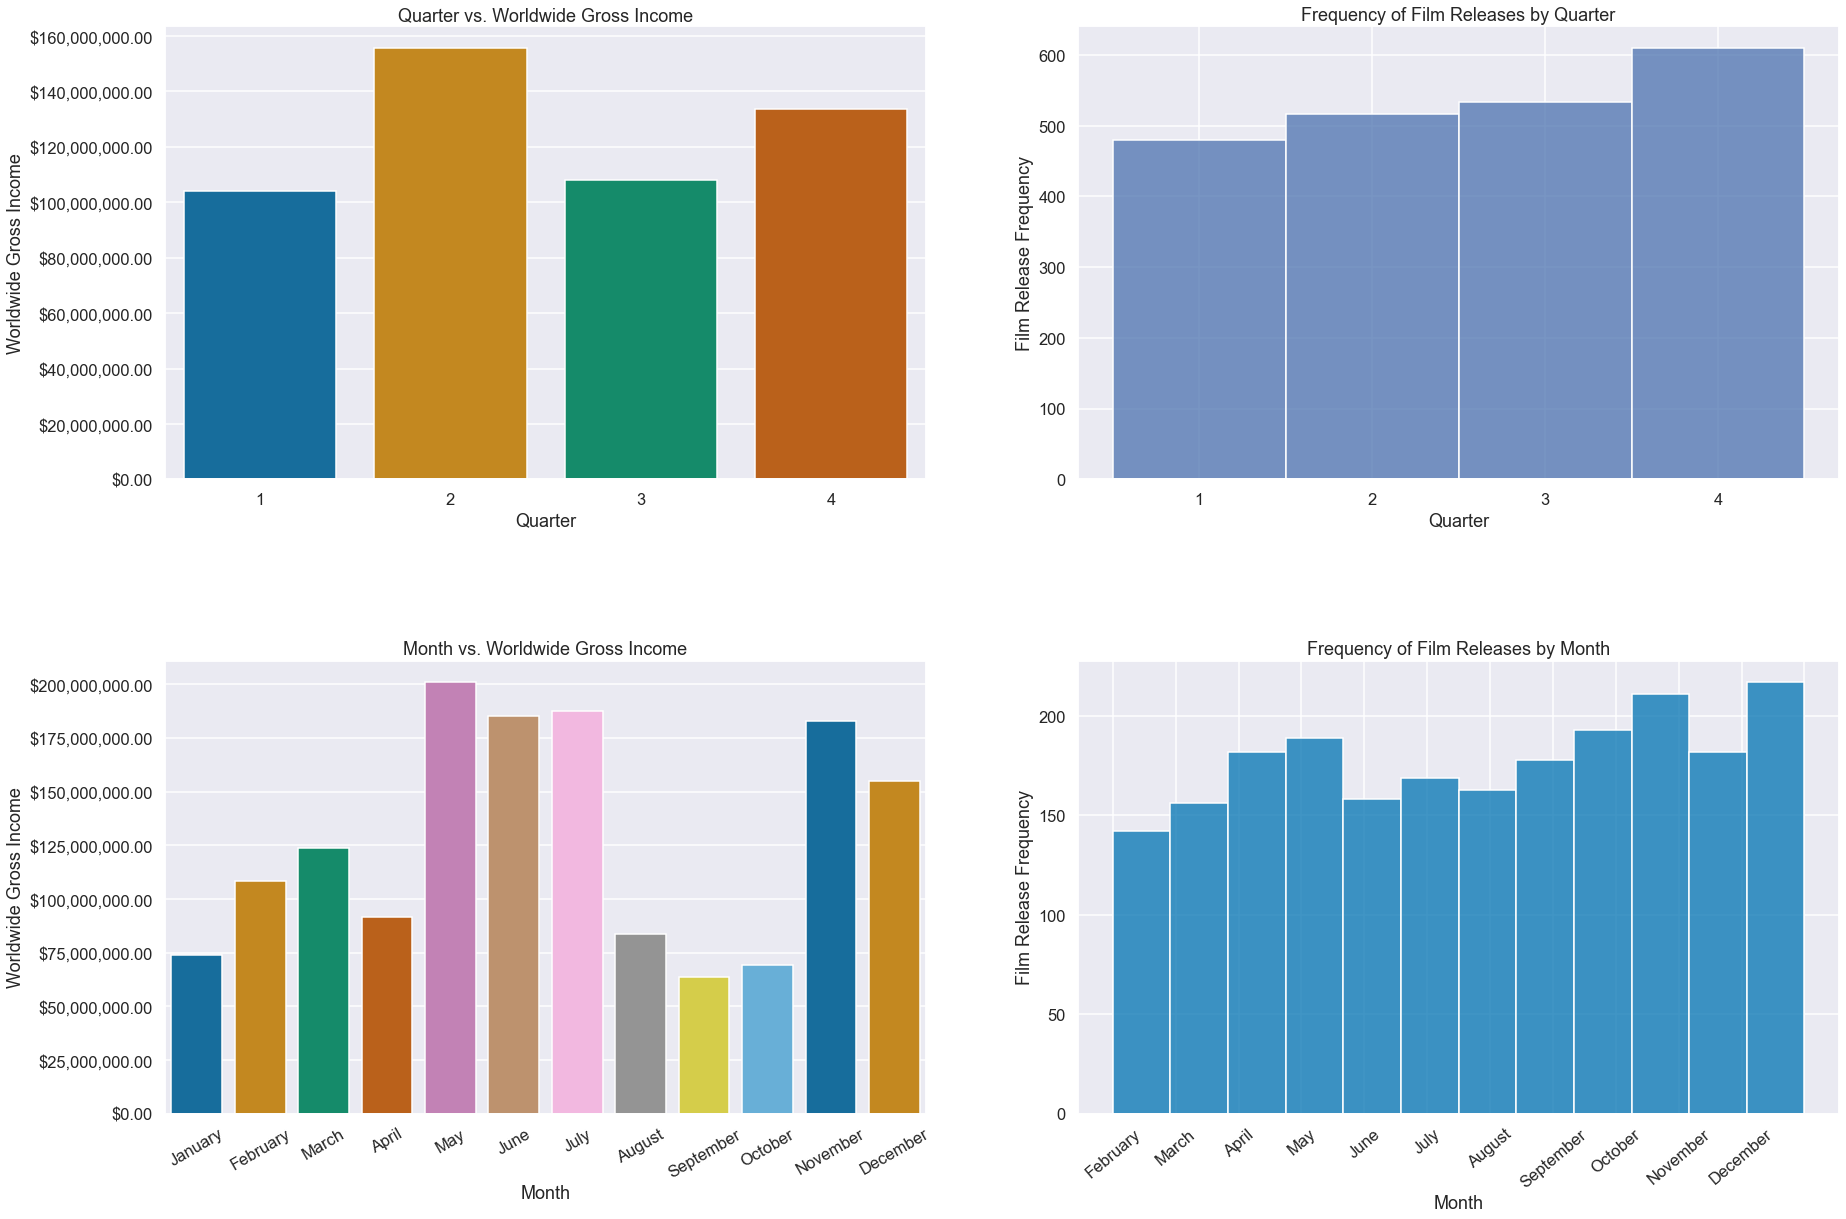

In [50]:
#seaborn visualization of quarters versus worldwide_gross

fig, axes = plt.subplots( 2, 2, figsize = (30,20))
sns.set_theme()
sns.set_context('talk')
plt.subplots_adjust(hspace = .4)

#setting y axis formatting to include $ and comma-separation
formatter = ticker.FuncFormatter(lambda x, p: '${:,.2f}'.format(x))

#hardcode for label strings
month_labels = ['January', 'February', 'March', 'April','May', 'June', 'July', 'August', 'September', 'October', 'November',  'December']

#x and y values for gross income plots
#x values
annual_quarters = worldwidegross_q.index
months = worldwidegross_m.index
#y values
worldwidegross_quarters = worldwidegross_q['cleaned_ww_gross']
worldwidegross_months = worldwidegross_m['cleaned_ww_gross']


#x and data values for frequency plots
#x values
quarters_freq = recent_movie_budgets['q']
months_freq = recent_movie_budgets['release_month']

#data values
release_frequency_q = recent_movie_budgets['q'].value_counts()
release_frequency_m = recent_movie_budgets['release_month'].value_counts()



#Plot 1 [0,0]
sns.barplot(ax = axes[0,0], x = annual_quarters, y = worldwidegross_quarters, palette = 'colorblind')
axes[0,0].set(xlabel="Quarter", ylabel="Worldwide Gross Income")
axes[0,0].set_title("Quarter vs. Worldwide Gross Income")
axes[0,0].yaxis.set_major_formatter(formatter)


#Plot 2 [0,1]
sns.histplot(ax = axes[0,1], data = release_frequency_q, x = quarters_freq, bins = 4)
axes[0,1].set_title("Frequency of Film Releases by Quarter")
axes[0,1].set(xlabel = "Quarter", ylabel = "Film Release Frequency")

#Plot 3 [1,0]
sns.barplot(ax = axes[1,0], x = months, y = worldwidegross_months, palette = 'colorblind')
sns.set_palette('colorblind')
axes[1,0].set(xlabel="Month", ylabel="Worldwide Gross Income")
axes[1,0].set_title("Month vs. Worldwide Gross Income")
axes[1,0].set_xticklabels(month_labels, rotation = 30)
axes[1,0].yaxis.set_major_formatter(formatter)


#Plot 4 [1,1]
sns.histplot(ax = axes[1,1], data = release_frequency_m , x = months_freq , bins = 12)
axes[1,1].set_title("Frequency of Film Releases by Month")
axes[1,1].set(xlabel = "Month", ylabel = "Film Release Frequency")
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axes[1,1].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1,1].set_xticklabels(month_labels, rotation = 40);


Observing the two graphs that track income and release frequency by month, it appears that May through July are the most profitable while October through December see the most films being released. I chose to narrow in on those months to compare film gross versus film production budgets to determine average net incomes.  
Here, I also subset the data to only use the metrics I want to compare.

In [36]:
##subsets of movie_budgets grouped by season to isolate only net_income mean

##movie information for May-July stored as summer_budgets
summer_budgets = recent_movie_budgets.loc[(recent_movie_budgets['release_month']).isin([5,6,7])] 
summer_budgets = summer_budgets[['release_month','net_income']].groupby('release_month').mean()

##movie information for October-December stored as fall_budgets
fall_budgets = recent_movie_budgets.loc[(recent_movie_budgets['release_month']).isin([10,11,12])]
fall_budgets = fall_budgets[['release_month','net_income']].groupby('release_month').mean()

From here, I took this data and generated one net income graph for each of the selected timeframes.

[Text(0, 0, 'October'), Text(1, 0, 'November'), Text(2, 0, 'December')]

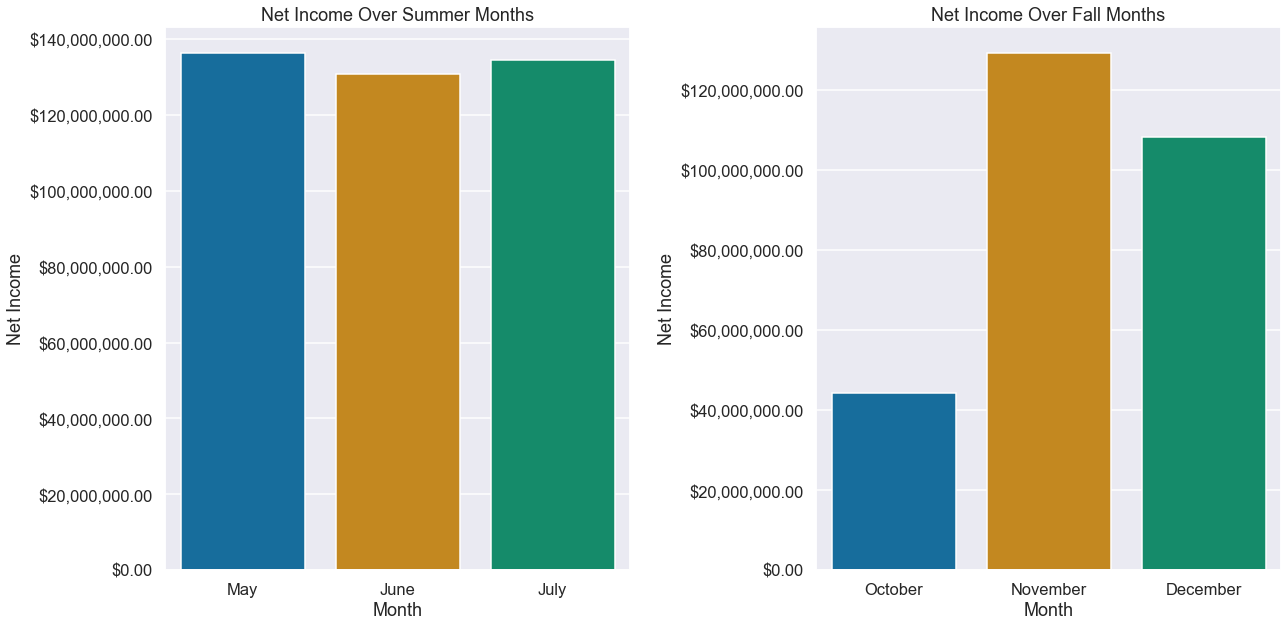

In [37]:
#plotting two graphs to compare net_income for the selected months

fig, axes = plt.subplots( 1,2, figsize = (20,10))
plt.subplots_adjust(wspace = .4)

#set variables for summer and fall datasets
summer_net = summer_budgets['net_income']
summer_months = summer_budgets.index

fall_net = fall_budgets['net_income']
fall_months = fall_budgets.index

#Plot 1 [0]
sns.barplot(ax = axes[0], x = summer_months, y = summer_net, palette = 'colorblind')
axes[0].yaxis.set_major_formatter(formatter)
axes[0].set(xlabel="Month", ylabel="Net Income")
axes[0].set_title("Net Income Over Summer Months")
axes[0].set_xticklabels(['May', 'June', 'July'])

#Plot 2 [1]
sns.barplot(ax = axes[1], x = fall_months, y = fall_net, palette = 'colorblind')
axes[1].yaxis.set_major_formatter(formatter)
axes[1].set(xlabel="Month", ylabel="Net Income")
axes[1].set_title("Net Income Over Fall Months")
axes[1].set_xticklabels(['October', 'November', 'December'])


In [40]:
#created some data sets to measure gross and net income over quarters and months

monthly_net = recent_movie_budgets[['release_month','net_income']].groupby('release_month').mean()
quarter_net = recent_movie_budgets[['q', 'net_income']].groupby('q').mean()

I was interested in seeing if there was any correlation or connection with the most profitable months and months with lower frequencies of film releases, so I decided to generate a scatter plot that measured frequency (x-axis), net income (y-axis) and denoted where each month fell by using a different colored plot point.

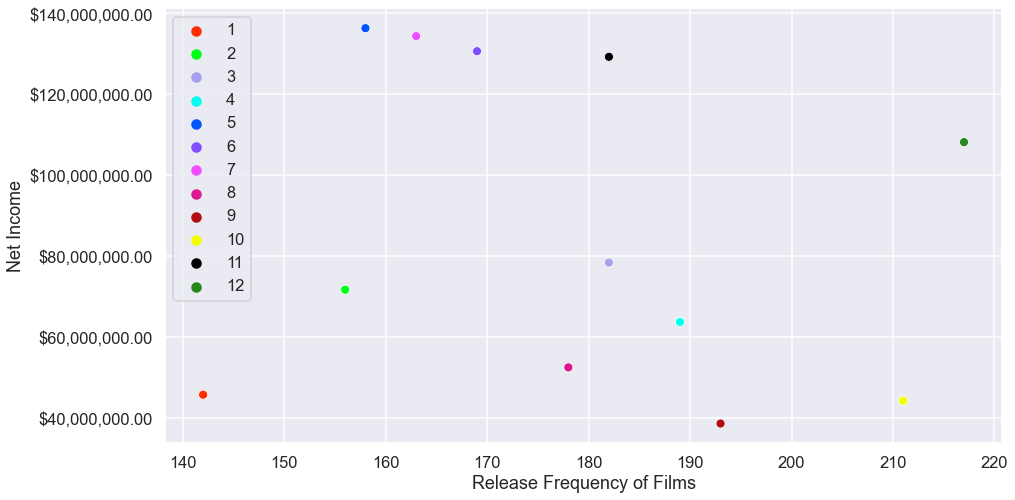

In [42]:
fig, ax = plt.subplots(figsize = (15,8))
#to make each month different, I created my own palette
colors = ['#FF2D00','#00FF17','#A6A0EF','#00FFF0','#0055FF','#814EFF','#EF4EFF','#DC168E','#B20D12','#F3FF00','#000000','#27871A']


graph = sns.scatterplot(x = release_frequency_m, y = monthly_net['net_income'], hue = monthly_net.index, palette = colors, legend = 'full')
ax.yaxis.set_major_formatter(formatter)
ax.set(xlabel = 'Release Frequency of Films', ylabel = 'Net Income')
#legend formatting
ax.legend()



The scatter plot supports that summer months are some of the most profitable months for film releases. November can also be observed as a successful month based on these metrics.  

Below, I wanted to check net income per month for the entire year and it seems to correlate exactly with gross income.

[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

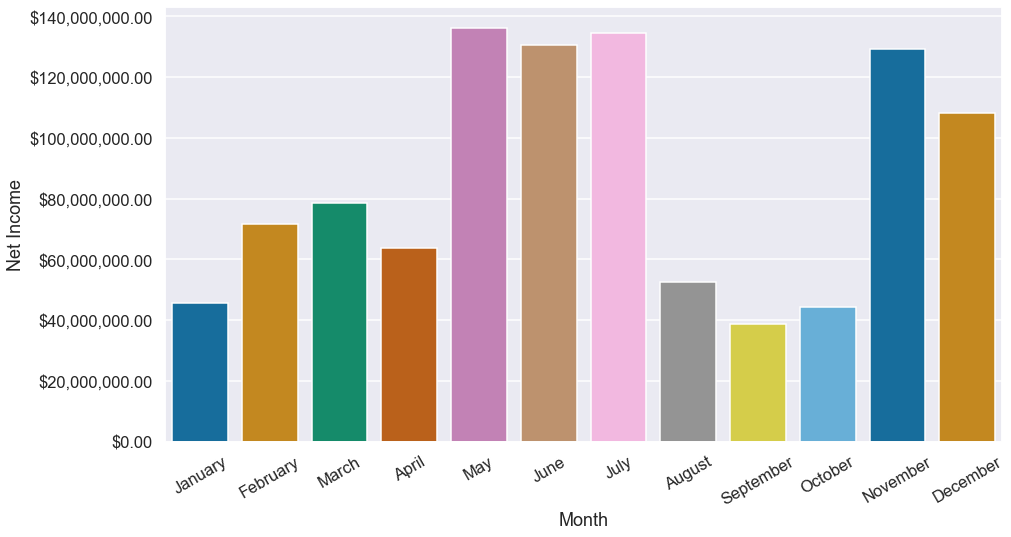

In [43]:
fig, ax = plt.subplots(figsize = (15,8))

sns.barplot(x = monthly_net.index, y = monthly_net['net_income'], palette = 'colorblind')
ax.yaxis.set_major_formatter(formatter)
ax.set(xlabel = 'Month', ylabel = 'Net Income')
ax.set_xticklabels(month_labels, rotation = 30)

A bonus graph of net income by quarter, since that's where I started.

[Text(0.5, 0, 'Quarter'), Text(0, 0.5, 'Net Income')]

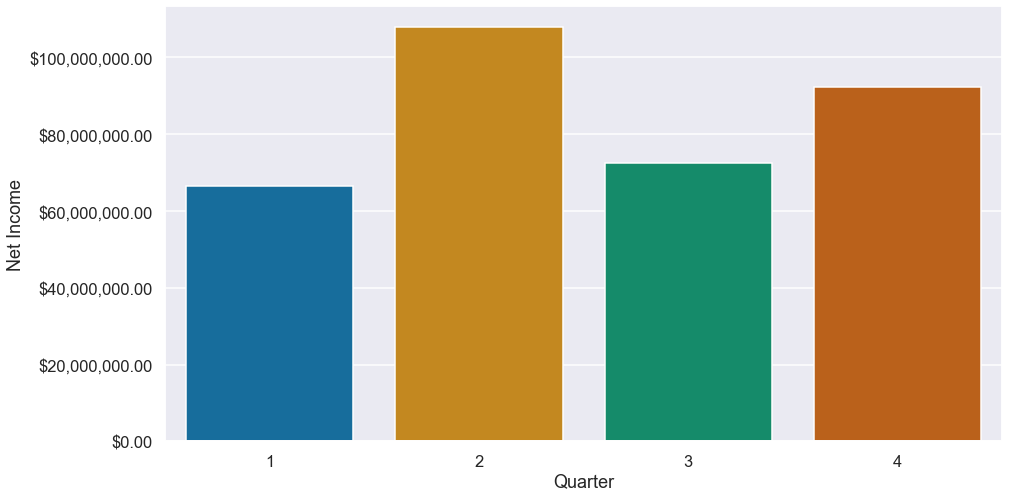

In [44]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = quarter_net.index, y = quarter_net['net_income'], palette = 'colorblind')
ax.yaxis.set_major_formatter(formatter)
ax.set(xlabel = 'Quarter', ylabel = 'Net Income')